In [148]:
import time
import os
from functools import partial
from typing import (
  Tuple, List, Dict, Any, Sequence, Callable)

import haiku as hk
import jax
import jax.numpy as jnp
import jax.random as jr 
import jraph
import optax
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from mnist_to_graphs import pad_graph_to_value

#### globals

In [149]:
Array = jnp.ndarray
Graph = jraph.GraphsTuple
Key = jr.PRNGKey
Params = hk.Params

# Train
N_GRAPHS = 2000
LOG_SCALE = False 
SPLIT = 0.1
LR = 2.e-4 # 2e-5
BATCH_SIZE = 64
N_STEPS = 10_000
PATIENCE = 30
EVAL_FREQ = 50
PAD_VALUE = 4096 #8128 
# Model
F = 64
E = 32
N_LAYERS = 2
N_NET_LAYERS = 3
ACTIVATION = jax.nn.gelu
DROPOUT_RATE = 0.25
USE_EMBEDDING = True 

# Use graphs of PDFs made of fully-connected subgraphs of R-PDFs
R_subgraphs = True

#### utils

In [150]:
resolution = 1024 
all_redshifts = [
  0., 0.5, 1., 2., 3.]
all_R_values = [
 "5.0", "10.0", "15.0", "20.0", "25.0", "30.0"]

def get_R_z_string(R_values, z_values, n_moments_calculate=3):
    if isinstance(R_values, list):
        if len(R_values) == len(all_R_values):
            R_string = "all"
        else:
            R_string = "_".join([str(float(R)) for R in R_values])
    else:
        R_string = str(R_values)
    if isinstance(z_values, list):
        if len(z_values) == len(all_redshifts):
            z_string = "all"
        else:
            z_string = "_".join([str(float(z)) for z in z_values])
    else:
        z_string = str(z_values)

    return f"x={resolution}_R={R_string}_z={z_string}_nm={n_moments_calculate}"

def print_graph_attributes(g):
  attrs = [
    "nodes", 
    "edges", 
    "senders", 
    "receivers", 
    "globals", 
    "n_node", 
    "n_edge"]

  for a in attrs:
    val = getattr(g, a)
    print(f"\033[94m {a} = {val.shape if val is not None else None}")

def adjacency_matrix(sender_indices, receiver_indices, n_nodes=None):
  # Determine the number of nodes in the graph if not provided
  if n_nodes is None:
    n_nodes = max(max(sender_indices), max(receiver_indices)) + 1

  # Create an empty adjacency matrix
  adj_matrix = np.zeros((n_nodes, n_nodes))

  # Set entries in the adjacency matrix for each edge
  for sender, receiver in zip(sender_indices, receiver_indices):
    adj_matrix[sender, receiver] = 1 
    adj_matrix[receiver, sender] = 1 

  return adj_matrix

def get_dataloaders(
  simulations, 
  parameters, 
  rng, 
  log_scale=False,
  batch_size=BATCH_SIZE, 
  split=SPLIT, 
  repeat=True):
  n_train = int((1. - split) * len(simulations))

  batch_iterator = lambda d: d.batch(batch_size).as_numpy_iterator()

  if log_scale:
    simulations = np.log10(simulations)

  train_dataset = tf.data.Dataset.from_tensor_slices(
    (simulations[:n_train], parameters[:n_train]))
  valid_dataset = tf.data.Dataset.from_tensor_slices(
    (simulations[n_train:], parameters[n_train:]))

  if repeat:
    train_dataset = train_dataset.repeat()
    valid_dataset = valid_dataset.repeat()

  train_dataset = train_dataset.shuffle(n_train, seed=int(rng.sum()))
  train_dataset = batch_iterator(train_dataset)
  valid_dataset = batch_iterator(valid_dataset)
  return train_dataset, valid_dataset

#### data

In [151]:
prng_seq = hk.PRNGSequence(0)

data_dir = "/Users/Jed.Homer/phd/lfi/jaxdelfi/data/"

redshifts = all_redshifts[:1]
R_values = all_R_values[1:4]

R_idx = [all_R_values.index(R) for R in R_values]
z_idx = [redshifts.index(z) for z in redshifts]

print(f"Running for redshifts: \n{redshifts}" + 
      f"\nat resolution x={resolution}" + 
      f"with R values:\n{R_values}.")

Rz_string = get_R_z_string(R_values, redshifts, n_moments_calculate=3)

Running for redshifts: 
[0.0]
at resolution x=1024with R values:
['10.0', '15.0', '20.0'].


#### data
* for each moments datavector, make fully connected subgraph for each redshift, then concatenate all the redshift graphs together...

In [152]:
alpha = jnp.array([0.3175, 0.049, 0.6711, 0.9624, 0.834])
parameters = jnp.load(
  os.path.join(data_dir, f"ALL_PDFS_PARAMS.npy")) 

# (z, n, d, R)
all_pdfs = np.load(
  "/Users/Jed.Homer/phd/lfi/jaxdelfi_pdf/data/ALL_PDFS_1024_egg.npy") # downloaded again
all_pdfs_parameters = np.load(
  os.path.join(data_dir, "ALL_PDFS_PARAMS.npy"))

deltas = np.load("/Users/Jed.Homer/phd/lfi/quijote_lh_pdf_data/DELTAS.npy")

def get_z_R_from_pdfs(pdfs):
  """ 
    Grab the chosen PDFs for 
    redshifts and smoothing radii. 
  """
  print("pdfs", pdfs.shape)
  n_z, n_pdfs, *_ = pdfs.shape
  pdfs_z = jnp.stack([pdfs[z] for z in z_idx])
  pdfs_z_R = jnp.stack([pdfs_z[..., R] for R in R_idx], axis=-1)
  pdfs_z_R = jnp.moveaxis(pdfs_z_R, 0, 1) # swap redshift and batch
  return pdfs_z_R

fiducial_pdfs = jnp.load(
  os.path.join(data_dir, f"ALL_FIDUCIAL_PDFS_1024.npy"))

latin_pdfs = get_z_R_from_pdfs(all_pdfs)
fiducial_dv = get_z_R_from_pdfs(fiducial_pdfs)
fiducial_dv = fiducial_dv.mean(axis=0)[jnp.newaxis, :]

simulations = latin_pdfs 

print(latin_pdfs.shape)
print(fiducial_dv.shape)

n_sims, parameter_dim = parameters.shape
n_pdfs, n_z, pdf_dim, n_R = fiducial_dv.shape
data_dim = np.prod(fiducial_dv.shape)

parameters.shape, simulations.shape, fiducial_dv.shape

pdfs (5, 2000, 99, 7)
pdfs (5, 15000, 99, 7)
(2000, 1, 99, 3)
(1, 1, 99, 3)


((2000, 5), (2000, 1, 99, 3), (1, 1, 99, 3))

In [153]:
cora = False 
Rz_string_cora = "cora_" + Rz_string
load_string = Rz_string_cora if cora else Rz_string
delfi_data_dir = "/Users/Jed.Homer/phd/lfi/jaxdelfi/data/"
cuts = []
for i_z, z in enumerate(redshifts):
  for i_R, R in enumerate(R_values):
    cut_z_R = jnp.load(
      os.path.join(
        delfi_data_dir, f"cut_idx_z={redshifts[i_z]}_R={R_values[i_R]}_{load_string}.npy"))
    cuts.append(cut_z_R)
    print(cut_z_R.shape)

(40,)
(31,)
(25,)


In [154]:
# plt.figure()
# for a, b, cut, cut_pdf in zip(
#   np.cumsum([0] + [len(cut) for cut in cuts[:-1]]),
#   np.cumsum([len(cut) for cut in cuts]),
#   cuts,
#   [fiducial_dv[:, :, cuts[R], R] for R, _ in enumerate(R_values)]):
#   plt.plot(range(a, b), cut_pdf.squeeze())
# plt.show()

In [155]:
# simulations = jnp.concatenate(
#   [latin_pdfs[:, :, cuts[R], R] for R, _ in enumerate(R_values)], axis=-1)
# fiducial_dv = jnp.concatenate(
#   [fiducial_dv[:, :, cuts[R], R] for R, _ in enumerate(R_values)], axis=-1)

# simulations.shape, fiducial_dv.shape, latin_pdfs.shape

In [156]:
# simulations = all_pdfs_z_R
data_dim = np.prod(simulations.shape[1:])
data_dim

297

#### graph builders

In [157]:
def make_subgraphs(pdfs, cuts, deltas=None, n_idx=None, deselect_rng=None):
  """ 
    Pass in as many integers as moments for each R, z moment vector 
  """
  # Vmapping, so this is z-axis
  all_g_z = []
  for i, (z, pdf_z) in enumerate(zip(redshifts, pdfs)):
    # Give every node (a moment) R and z information
    n_R, n_pdf_bins = len(R_values), pdfs.shape[-1]
    # Rs = jnp.array([float(R) for R in R_values] * int(n_pdf_bins / len(R_values)))
    # Rs = Rs / Rs.max()
    # zs = jnp.array([z] * n_pdf_bins)

    # print("pdf_z", pdf_z.shape)
    # print([pdf_z[cuts[R], R] for R, _ in enumerate(R_values)])
    pdf_z_R = jnp.concatenate([
      pdf_z[cuts[R], R] for R, _ in enumerate(R_values)])
    # print("len", cuts[0])
    # Rs = jnp.concatenate([ 
    #   jnp.multiply(jnp.array([R_]), jnp.ones(len(cuts[R]))) for R, R_ in enumerate(R_values)])
    # Rs = jnp.array([R_] * len(cuts[R]) for R, R_ in enumerate(R_values))
    # zs = jnp.ones_like(Rs) * z

    # Randomly de-select nodes  
    # print("pdf shape", pdf_z_R.flatten().shape)
    # node_datas = [pdf_z_R.flatten(), Rs]
    # node_datas = node_datas + [zs] if len(redshifts) > 1 else node_datas
    node_datas = [pdf_z_R.flatten()]
    # print([_.shape for _ in node_datas])
    # Concatenate for vmapping ...
    node_features = jnp.stack(node_datas, axis=1)
    node_features_ = node_features
    n_node_per_graph = np.prod(pdf_z_R.shape)

    g_z = jraph.get_fully_connected_graph(
      node_features=node_features_,
      n_node_per_graph=n_node_per_graph,
      n_graph=1,
      global_features=None,
    add_self_edges=True)
    all_g_z.append(g_z)
  return all_g_z 

def make_R_subgraphs(pdfs, cuts, deltas=None):
  """ 
    Pass in as many integers as moments for each R, z moment vector 
  """
  # Vmapping, so this is z-axis
  all_g_z_R = []
  R_floats = [float(R) for R in R_values]
  for i, (z, pdf_z) in enumerate(zip(redshifts, pdfs)):
    for R, pdf_R in enumerate(pdf_z.T):
      pdf_z_R = pdf_z[cuts[R], R]
      Rs = jnp.full(pdf_z_R.shape, R_floats[R]) / max(R_floats)
      node_features = [pdf_z_R, Rs]
      if deltas is not None:
        node_features = node_features + [deltas[cuts[R]]]
      node_features = jnp.stack(
        node_features, axis=1)
      n_node_per_graph = np.prod(pdf_z_R.shape)
      g_z_R = jraph.get_fully_connected_graph(
        node_features=node_features,
        n_node_per_graph=n_node_per_graph,
        n_graph=1,
        global_features=None,
        add_self_edges=True)
      all_g_z_R.append(g_z_R)
  return all_g_z_R

In [158]:
def make_graph_from_R_subgraphs(subgraphs):
  """ 
        Make ONE graph from fully connected redshift-subgraphs
        - NO connections between subgraphs of different redshift
        - for vmapping, may need to remove all "axis adding"...
            -> globals for one graph created as (1, 2) due to added axis 
               so instead make (2,) so they are vmap-stacked ast (B, 2) not (B, 1, 2)
  """
  n_node = sum([g_z.n_node for g_z in subgraphs])
  n_edge = sum([g_z.n_edge for g_z in subgraphs])
  # Note: n_edge is redundant for one redshift + fully connected
  cardinality = jnp.array([n_node, n_edge]).astype(jnp.float32).T.squeeze()
  return jraph.GraphsTuple(
    nodes=jnp.concatenate([
      g_z.nodes for g_z in subgraphs]).squeeze(),
    edges=None, 
    # Since graph is made of subgraphs, need to re-index S and R for main_graph indexing...
    senders=jnp.concatenate([
      g_z.n_node * n + g_z.senders 
      for n, g_z in enumerate(subgraphs)]),
    receivers=jnp.concatenate([
      g_z.n_node * n + g_z.receivers 
      for n, g_z in enumerate(subgraphs)]),
    n_node=n_node,
    n_edge=n_edge,
    globals=cardinality)
#   n_node = sum([g_z.n_node for g_z in subgraphs])
#   n_edge = sum([g_z.n_edge for g_z in subgraphs])
#   # Note: n_edge is redundant for one redshift + fully connected
#   cardinality = jnp.array([n_node, n_edge]).astype(jnp.float32).T.squeeze()
#   print([g_z.nodes.shape for g_z in subgraphs])
#   return jraph.GraphsTuple(
#     nodes=jnp.concatenate([
#       g_z.nodes for g_z in subgraphs], axis=1).squeeze(),
#     edges=None, 
#     # Since graph is made of subgraphs, need to re-index S and R for main_graph indexing...
#     senders=jnp.concatenate([
#       g_z.n_node * n + g_z.senders 
#       for n, g_z in enumerate(subgraphs)], axis=1),
#     receivers=jnp.concatenate([
#       g_z.n_node * n + g_z.receivers 
#       for n, g_z in enumerate(subgraphs)], axis=1),
#     n_node=n_node,
#     n_edge=n_edge,
#     globals=cardinality)

/Users/Jed.Homer/miniconda3/envs/jraph/lib/python3.10/site-packages/jraph/_src/utils.py:882: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  num_node_features = jax.tree_leaves(node_features)[0].shape[0]


 nodes = (64, 96, 3)
 edges = None
 senders = (64, 3186)
 receivers = (64, 3186)
 globals = (64, 2)
 n_node = (64, 1)
 n_edge = (64, 1)


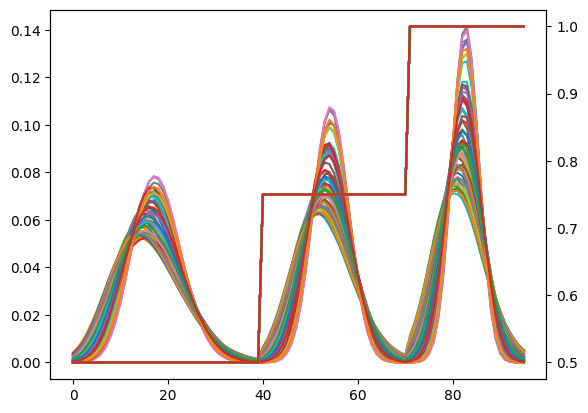

In [159]:
rng = jr.PRNGKey(0)

train_dataset, valid_dataset = get_dataloaders(
  latin_pdfs, parameters, rng=rng)

def make_R_graph(x, cuts, deltas=None):
  return make_graph_from_R_subgraphs(make_R_subgraphs(x, cuts, deltas=deltas))

_make_R_graph = partial(make_R_graph, cuts=cuts, deltas=deltas)

x, y = next(train_dataset)
G = jax.vmap(_make_R_graph)(x)
print_graph_attributes(G)

fig, ax = plt.subplots()
ax_ = ax.twinx()
for _ in range(G.nodes.shape[0]):
  pdf, Rs, deltas = G.nodes[_, :, :].T
  ax.plot(pdf)
  ax_.plot(Rs)
plt.show()

In [160]:
rng = jr.PRNGKey(0)

train_dataset, valid_dataset = get_dataloaders(
  latin_pdfs, parameters, rng=rng)

x, y = next(train_dataset)
# g = jax.vmap(make_R_subgraphs, in_axes=(0, None))(x, cuts)
# G = make_graph_from_R_subgraphs(g)
G = jax.vmap(_make_R_graph)(x)
print_graph_attributes(G)

 nodes = (64, 96, 3)
 edges = None
 senders = (64, 3186)
 receivers = (64, 3186)
 globals = (64, 2)
 n_node = (64, 1)
 n_edge = (64, 1)


In [161]:
def make_graph_from_subgraphs(subgraphs):
  """ 
        Make ONE graph from fully connected redshift-subgraphs
        - NO connections between subgraphs of different redshift
        - for vmapping, may need to remove all "axis adding"...
            -> globals for one graph created as (1, 2) due to added axis 
               so instead make (2,) so they are vmap-stacked ast (B, 2) not (B, 1, 2)
  """
  n_node = sum([g_z.n_node for g_z in subgraphs])
  n_edge = sum([g_z.n_edge for g_z in subgraphs])
  # Note: n_edge is redundant for one redshift + fully connected
  cardinality = jnp.array([n_node, n_edge]).astype(jnp.float32)
#   cardinality = cardinality.reshape(2,)
  return jraph.GraphsTuple(
    nodes=jnp.concatenate([
      g_z.nodes for g_z in subgraphs]),
    edges=None, 
    # Since graph is made of subgraphs, need to re-index S and R for main_graph indexing...
    senders=jnp.concatenate([
      g_z.n_node * n + g_z.senders 
      for n, g_z in enumerate(subgraphs)]),
    receivers=jnp.concatenate([
      g_z.n_node * n + g_z.receivers 
      for n, g_z in enumerate(subgraphs)]),
    n_node=n_node,
    n_edge=n_edge,
    globals=cardinality.squeeze())

In [162]:
rng = jr.PRNGKey(0)

train_dataset, valid_dataset = get_dataloaders(
  latin_pdfs, parameters, rng=rng)

x, y = next(train_dataset)
print(x.shape, y.shape)

# Test vmapping a subgraph creation
g = jax.vmap(make_subgraphs, in_axes=(0, None, None))(x, cuts, deltas)
print("\n")
# Creates a graph tuple with all the graphs in
# print(g)
print_graph_attributes(g[0])

(64, 1, 99, 3) (64, 5)


 nodes = (64, 96, 1)
 edges = None
 senders = (64, 9216)
 receivers = (64, 9216)
 globals = None
 n_node = (64, 1)
 n_edge = (64, 1)


In [163]:
if R_subgraphs:
  def make_graph(data, cuts, deltas):
    """ This is used in training. """
    g = make_graph_from_R_subgraphs(
      make_R_subgraphs(data, cuts, deltas))
    return g
else:
  def make_graph(data, cuts):
    """ This is used in training. """
    g = make_graph_from_subgraphs(
      make_subgraphs(data, cuts))
    return g

g = jax.vmap(_make_R_graph)(x)
# g = g._replace(nodes=g.nodes.reshape(-1, 3))
print_graph_attributes(g)

 nodes = (64, 96, 3)
 edges = None
 senders = (64, 3186)
 receivers = (64, 3186)
 globals = (64, 2)
 n_node = (64, 1)
 n_edge = (64, 1)


#### model

##### resnet

In [164]:
# Try changing this eps value
layernorm_kwargs = dict(
  axis=1, create_scale=True, create_offset=True, eps=1e-8)

class LinearResNet(hk.Module):
  def __init__(
    self, 
    hidden_sizes: Sequence[int],
    activation: Callable = jax.nn.leaky_relu,
    activate_final: bool = False):
    super().__init__()
    self.hidden_sizes = hidden_sizes
    self.activation = activation
    self.activate_final = activate_final
    self.use_layernorm = True 

  def __call__(self, x, dropout_rate=0.):
    z = x
    for f in self.hidden_sizes:
      h = self.activation(z)
      if self.use_layernorm:
        h = hk.LayerNorm(**layernorm_kwargs)(h)
      h = hk.Linear(f)(h)
      h = self.activation(h)
      if dropout_rate:
        h = hk.dropout(hk.next_rng_key(), dropout_rate, h)
      if self.use_layernorm:
        h = hk.LayerNorm(**layernorm_kwargs)(h)
      h = hk.Linear(f, w_init=jnp.zeros)(h)
      if dropout_rate:
        h = hk.dropout(hk.next_rng_key(), dropout_rate, h)
      z = z + h 
    return self.activation(z) if self.activate_final else z

##### gnn

In [165]:
net_kwargs = dict(
  hidden_sizes=[F] * N_NET_LAYERS, 
  activation=ACTIVATION)

def get_node_update_fn(dropout_rate: float = None):
  @jraph.concatenated_args 
  def node_update_fn(feats: Array) -> Array:
    """ Node update function for graph net. """
    h = ACTIVATION(hk.Linear(F)(feats))
    if dropout_rate is not None and dropout_rate > 0.:
      h = hk.dropout(hk.next_rng_key(), dropout_rate, h)
    h = LinearResNet(**net_kwargs)(h, dropout_rate=dropout_rate)
    return h
  return node_update_fn

def get_global_update_fn(dropout_rate: float = None):
  @jraph.concatenated_args
  def update_global_fn(feats: Array) -> Array:
    """ Global update function for graph net. """
    h = ACTIVATION(hk.Linear(F)(feats))
    h = LinearResNet(**net_kwargs)(h, dropout_rate=dropout_rate)
    if dropout_rate is not None and dropout_rate > 0.:
      h = hk.dropout(hk.next_rng_key(), dropout_rate, h)
    return hk.Linear(parameter_dim, with_bias=True)(h)
  return update_global_fn

def get_normlinear(dropout_rate: float = None):
  def _apply(x):
    h = hk.LayerNorm(**layernorm_kwargs)(x)
    h = hk.Linear(E, with_bias=False)(h)
    if dropout_rate is not None and dropout_rate > 0.:
      h = hk.dropout(hk.next_rng_key(), dropout_rate, h) 
    return h 
  return _apply if USE_EMBEDDING else None

def net_fn(graph: Graph, dropout_rate: float = None) -> Graph:
  embedder = jraph.GraphMapFeatures(
    embed_node_fn=get_normlinear(dropout_rate), 
    embed_global_fn=get_normlinear(dropout_rate)) 
  graph = embedder(graph)
  for _ in range(N_LAYERS):
    net = jraph.GraphNetwork(
      update_edge_fn=None,
      update_node_fn=get_node_update_fn(dropout_rate),
      update_global_fn=get_global_update_fn(dropout_rate))
    graph = net(graph)
  return graph

#### train

In [166]:
train_dataset, valid_dataset = get_dataloaders(
    simulations, parameters, rng, log_scale=LOG_SCALE)

d, y = next(train_dataset)

print("data", d.shape, "\n")

g = make_graph(d[0], cuts, deltas)
G = jax.vmap(_make_R_graph)(d)
%timeit jax.vmap(_make_R_graph)(d)

print("g")
print_graph_attributes(g)
print("G")
print_graph_attributes(G)

gs = [_make_R_graph(d_) for d_ in d]
%timeit jraph.batch(gs)
gs = jraph.batch(gs)
print("batched")
print_graph_attributes(gs)

data (64, 1, 99, 3) 

9.13 ms ± 205 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
g
 nodes = (96, 3)
 edges = None
 senders = (3186,)
 receivers = (3186,)
 globals = (2,)
 n_node = (1,)
 n_edge = (1,)
G
 nodes = (64, 96, 3)
 edges = None
 senders = (64, 3186)
 receivers = (64, 3186)
 globals = (64, 2)
 n_node = (64, 1)
 n_edge = (64, 1)
12.3 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
batched
 nodes = (6144, 3)
 edges = None
 senders = (203904,)
 receivers = (203904,)
 globals = (128,)
 n_node = (64,)
 n_edge = (64,)


In [167]:
def batch_graphs(gs):
    """ Batch a vmapped graphs tuple. """
    G = jraph.GraphsTuple(
        nodes=jnp.concatenate(
          [g for g in gs.nodes]),
        edges=None,
        senders=jnp.concatenate([
          g + n * len(g) 
          for n, g in enumerate(gs.senders)]),
        receivers=jnp.concatenate([
          g + n * len(g) 
          for n, g in enumerate(gs.receivers)]),
        globals=gs.globals,
        n_node=gs.n_node,
        n_edge=gs.n_edge)
        # globals=jnp.concatenate([g for g in gs.globals]),
        # n_node=sum([g for g in gs.n_node]),
        # n_edge=sum([g for g in gs.n_edge]))
    return G

# def batch_graphs(gs):
#     G = jraph.GraphsTuple(
#         nodes=jnp.concatenate(
#           [g.nodes for g in gs]),
#         edges=None,
#         senders=jnp.concatenate(
#           [g.senders + n * len(g.senders) for n, g in enumerate(gs)]),
#         receivers=jnp.concatenate(
#           [g.receivers + n * len(g.receivers) for n, g in enumerate(gs)]),
#         globals=jnp.concatenate(
#           [g.globals for g in gs]),
#         n_node=jnp.sum([g.n_node for g in gs]),
#         n_edge=jnp.sum([g.n_edge for g in gs]))
#     return G

o = batch_graphs(G)
print_graph_attributes(o)

o.senders

 nodes = (6144, 3)
 edges = None
 senders = (203904,)
 receivers = (203904,)
 globals = (64, 2)
 n_node = (64, 1)
 n_edge = (64, 1)


DeviceArray([     0,      1,      2, ..., 200790, 200791, 200792], dtype=int32)

#### trainer functions

In [168]:
@partial(jax.jit, static_argnames=["net"])
def compute_loss(
  params: Params, 
  net: Graph,
  rng: Key,
  graph: Graph, 
  label: Array) -> Tuple[Array, Array]:
  #   Vmap along batch axis of graph
#   pred_graph = jax.vmap(
#       net.apply, in_axes=(None, None, 0)
#   )(params, rng, graph)
  pred_graph = net.apply(params, rng, graph)
  preds = pred_graph.globals
  print("preds", preds.shape)
  mask = jraph.get_graph_padding_mask(pred_graph)
  loss = (jnp.square(jnp.subtract(preds, label)) * mask[:, None]).mean()
  return loss, (None,)
 
@jax.jit
def get_graph_(d):
  gs = jax.vmap(_make_R_graph)(d)
  G = batch_graphs(gs)
  return G

def train(
  simulations: Array, 
  parameters: Array, 
  num_train_steps: int,
  patience: int = 10) -> Tuple[hk.Params, List]:
  """
    Pad only edges/nodes/senders/receivers.
    - these change size with number of nodes in graph
    - global attr constant shape for any graph with whatever n_nodes
  """
  rng = jr.PRNGKey(0)
  net = hk.transform(partial(net_fn, dropout_rate=DROPOUT_RATE))
  valid_rng = None
  valid_net = hk.transform(partial(net_fn, dropout_rate=0.))
    
  d = jnp.ones_like(fiducial_dv)
  print(d.shape)
  graph = get_graph_(d)
  print("d0", d[0].shape)
  #graph = make_graph(d[0], cuts=cuts)
  graph = get_graph_(d)
  print("init graph")
  print_graph_attributes(graph)

  # Initialize the network and optimizer.
  params = net.init(rng, graph)
  opt_init, opt_update = optax.adabelief(LR)
  opt_state = opt_init(params)
  print(f"n_params = {hk.data_structures.tree_size(params)}")

  compute_loss_fn = jax.value_and_grad(compute_loss, has_aux=True)
  
  counter = 0
  best_loss = jnp.inf
  train_losses, valid_losses = [], []
  for s in range(num_train_steps):
    epoch_train_losses, epoch_valid_losses = [], []

    train_dataset, valid_dataset = get_dataloaders(
      simulations, 
      parameters, 
      rng, 
      log_scale=LOG_SCALE, 
      batch_size=BATCH_SIZE, 
      repeat=False)

    for (d, y) in train_dataset:
      # Train
      graph = get_graph_(d)

      (train_loss, _), grad = compute_loss_fn(
        params, net, rng, graph, y)
      updates, opt_state = opt_update(grad, opt_state, params)
      params = optax.apply_updates(params, updates)

      epoch_train_losses.append(train_loss)

    for (d, y) in valid_dataset:
      # Validate
      graph = get_graph_(d)
      valid_loss, _ = compute_loss(
        params, valid_net, valid_rng, graph, y)

      epoch_valid_losses.append(valid_loss)

    epoch_valid_loss = np.mean(epoch_valid_losses) 
    train_losses.append(np.mean(epoch_train_losses))
    valid_losses.append(epoch_valid_loss)

    if s % EVAL_FREQ == 0:
      print(f'\rs: {s:06d} L_t: {train_loss:.4f} L_v: {valid_loss:.4f}', end="")
    
    if epoch_valid_loss < best_loss:
      best_loss = epoch_valid_loss
      counter = 0
    else:
      counter += 1
      if counter > patience:
        print(f"\nPatience met at epoch {s} with L_v={epoch_valid_loss:.2E}")
        break

  return params, np.asarray([train_losses, valid_losses])

In [169]:
# fiducial_graph = jax.vmap(make_graph, in_axes=(0, None))(fiducial_dv, cuts)
# print_graph_attributes(fiducial_graph)

# plt.hist(fiducial_graph.nodes[:, :, 2])

#### train

In [170]:
t0 = time.time()

params, losses = train(
  simulations, 
  parameters, 
  num_train_steps=N_STEPS, 
  patience=PATIENCE)

print(f"\n {(time.time() - t0) / 60.:.2f} mins.")

(1, 1, 99, 3)
d0 (1, 99, 3)
init graph
 nodes = (96, 3)
 edges = None
 senders = (3186,)
 receivers = (3186,)
 globals = (1, 2)
 n_node = (1, 1)
 n_edge = (1, 1)
n_params = 123060
preds (64, 5)
preds (8, 5)
preds (64, 5)
preds (8, 5)
s: 000000 L_t: 3083.1528 L_v: 130.8978
Patience met at epoch 34 with L_v=5.65E+01

 3.83 mins.


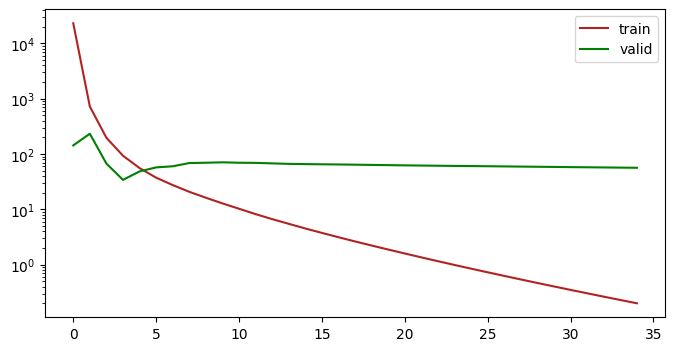

In [171]:
fig, ax = plt.subplots(1, 1, dpi=100, figsize=(8.,4.))
L_t, L_v = losses
# steps = range(0, N_STEPS, EVAL_FREQ)
# ax.semilogy(steps, L_t)
# ax.semilogy(steps, L_v)
ax.semilogy(L_t, color="firebrick", label="train")
ax.semilogy(L_v, color="green", label="valid")
ax.legend()
plt.show()

In [172]:
print(simulations.shape, latin_pdfs.shape)

all_graphs = get_graph_(simulations)

fiducial_graph = get_graph_(fiducial_dv)

print("latins:")
print_graph_attributes(fiducial_graph)
print("fiducial:")
print_graph_attributes(all_graphs)

(2000, 1, 99, 3) (2000, 1, 99, 3)


In [ ]:
# #plt.hist(all_graphs.nodes[:, 0].flatten())
# plt.figure()
# plt.hist(all_graphs.nodes[:, :, 0].mean(axis=0), bins=32)
# plt.show()

In [ ]:
net = hk.transform(partial(net_fn, dropout_rate=0.))
valid_net = hk.transform(partial(net_fn, dropout_rate=0., rng=None))

In [ ]:
# all_graphs_out = jax.vmap(
#     net.apply, in_axes=(None, None, 0))(params, rng, all_graphs)
# fiducial_graph_out = jax.vmap(
#     net.apply, in_axes=(None, None, 0))(params, rng, fiducial_graph)

all_graphs_out = net.apply(params, rng, all_graphs)
fiducial_graph_out = net.apply(params, rng, fiducial_graph)

preds = all_graphs_out.globals.squeeze()
fiducial_preds = fiducial_graph_out.globals.squeeze(0)

preds.shape, fiducial_preds.shape 

((2000, 5), (5,))

In [ ]:
class bcolors:
  HEADER = '\033[95m'
  OKBLUE = '\033[94m'
  OKCYAN = '\033[96m'
  OKGREEN = '\033[92m'
  WARNING = '\033[93m'
  FAIL = '\033[91m'
  ENDC = '\033[0m'
  BOLD = '\033[1m'
  UNDERLINE = '\033[4m'

print(bcolors.OKBLUE + "egg" + bcolors.WARNING + " bacon " )

egg bacon 


In [ ]:
n_train = int((1. - SPLIT) * n_sims)
n_train
c = np.concatenate([np.ones(n_train), np.zeros(int(0.1 * n_sims))])

(2000, 2) (2000, 2) (5,)


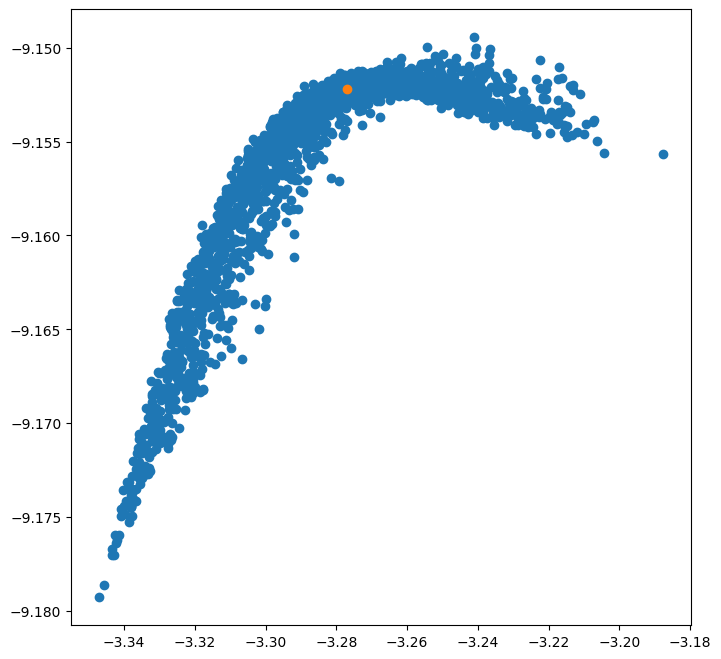

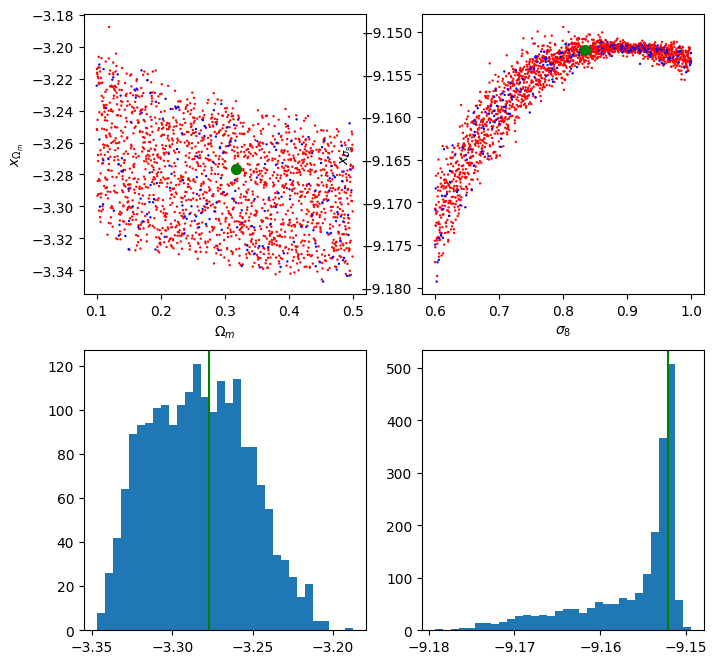

In [ ]:
target_idx = jnp.array([0, 4])
pred_targets = preds[:, target_idx]
parameter_targets = parameters[:, target_idx]

print(pred_targets.shape, parameter_targets.shape, fiducial_preds.shape)

fig, ax = plt.subplots(figsize=(8., 8.), dpi=100)
ax.scatter(*pred_targets.T)
ax.scatter(*fiducial_preds[target_idx].T)
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(8., 8.), dpi=100)
ax = axs[0, 0]

cmap = "bwr"
Om_lim = [0.05, 0.55]
s8_lim = [0.55, 1.25]

ax.scatter(parameter_targets[:2000, 0], pred_targets[:, 0], c=c, cmap=cmap, s=0.5)
ax.scatter(alpha[None, :][:, 0], fiducial_preds[0], s=50., color="green")
ax.set_ylabel("$x_{\Omega_m}$")
ax.set_xlabel("$\Omega_m$")
# plt.setp(ax, ylim=Om_lim)
# plt.setp(ax, xlim=Om_lim)
ax = axs[0, 1]
ax.scatter(parameter_targets[:2000, 1], pred_targets[:, 1], c=c, cmap=cmap, s=0.5)
ax.scatter(alpha[None, :][:, 4], fiducial_preds[4], s=50., color="green")
# plt.setp(ax, ylim=s8_lim)
# plt.setp(ax, xlim=s8_lim)
ax.set_ylabel("$x_{\sigma_8}$")
ax.set_xlabel("$\sigma_8$")
ax = axs[1, 0]
# ax.hist(parameter_targets[:2000, 0], histtype="step")
ax.hist(pred_targets[:, 0], bins=32)
ax.axvline(fiducial_preds[0], color="green")
# plt.setp(ax, xlim=Om_lim)
ax = axs[1, 1]
# ax.hist(parameter_targets[:2000, 1], histtype="step")
ax.hist(pred_targets[:, 1], bins=32)
ax.axvline(fiducial_preds[4], color="green")
# plt.setp(ax, xlim=s8_lim)
plt.show()